In [1]:
# Importing the important libraries

import os
import json
from dotenv import load_dotenv
from openai import OpenAI
import gradio as gr
import sqlite3

In [2]:
# Initialization by loading OPENAI api key and setting the model to gpt-5-nano
load_dotenv(override=True)

openai_api_key = os.getenv('OPENAI_API_KEY')
if openai_api_key:
    print(f"OpenAI API Key exists and begins {openai_api_key[:8]}")
else:
    print("OpenAI API Key not set")
    
MODEL = "gpt-5-nano"
openai = OpenAI()


OpenAI API Key exists and begins sk-proj-


In [3]:
# Setting the SQLite database to store the prices of the tickets 
DB = "prices.db"

with sqlite3.connect(DB) as conn:
    cursor = conn.cursor()
    cursor.execute('CREATE TABLE IF NOT EXISTS prices (city TEXT PRIMARY KEY, price REAL)')
    conn.commit()

In [4]:
# Function to set the prices of tickets in database
def set_ticket_price(city, price):
    with sqlite3.connect(DB) as conn:
        cursor = conn.cursor()
        cursor.execute('INSERT INTO prices (city, price) VALUES (?, ?) ON CONFLICT(city) DO UPDATE SET price = ?', (city.lower(), price, price))
        conn.commit()

In [5]:
ticket_prices = {"london":799, "paris": 899, "tokyo": 1420, "sydney": 2999}
for city, price in ticket_prices.items():
    set_ticket_price(city, price)

In [6]:
# Function to get ticket prices from database
def get_ticket_price(city):
    print(f"DATABASE TOOL CALLED: Getting price for {city}", flush=True)
    with sqlite3.connect(DB) as conn:
        cursor = conn.cursor()
        cursor.execute('SELECT price FROM prices WHERE city = ?', (city.lower(),))
        result = cursor.fetchone()
        return f"Ticket price to {city} is ${result[0]}" if result else "No price data available for this city"

In [7]:
get_ticket_price("London")

DATABASE TOOL CALLED: Getting price for London


'Ticket price to London is $799.0'

In [8]:
get_ticket_price("Sydney")

DATABASE TOOL CALLED: Getting price for Sydney


'Ticket price to Sydney is $2999.0'

In [9]:
get_ticket_price("Munich")

DATABASE TOOL CALLED: Getting price for Munich


'No price data available for this city'

In [10]:
# Setting the system prompt for the LLM so that it can act as chatbot for our airlines
system_message = """
You are a helpful assistant for an Airline called FlightAI.
Give short, courteous answers, no more than 1 sentence.
Always be accurate. If you don't know the answer, say so.
"""

In [11]:
# Writing the tool function following the openai syntax to pass tool to their LLM
price_function = {
    "name": "get_ticket_price",
    "description": "Get the price of a return ticket to the destination city.",
    "parameters": {
        "type": "object",
        "properties": {
            "destination_city": {
                "type": "string",
                "description": "The city that the customer wants to travel to",
            },
        },
        "required": ["destination_city"],
        "additionalProperties": False
    }
}
tools = [{"type": "function", "function": price_function}]
tools

[{'type': 'function',
  'function': {'name': 'get_ticket_price',
   'description': 'Get the price of a return ticket to the destination city.',
   'parameters': {'type': 'object',
    'properties': {'destination_city': {'type': 'string',
      'description': 'The city that the customer wants to travel to'}},
    'required': ['destination_city'],
    'additionalProperties': False}}}]

In [12]:
# Writing the chat function for gradio which has multiple tool call ability 
def chat(message, history):
    history = [{"role":h["role"], "content":h["content"]} for h in history]
    messages = [{"role": "system", "content": system_message}] + history + [{"role": "user", "content": message}]
    response = openai.chat.completions.create(model=MODEL, messages=messages, tools=tools)

    while response.choices[0].finish_reason=="tool_calls":
        message = response.choices[0].message
        responses = handle_tool_calls(message)
        messages.append(message)
        messages.extend(responses)
        response = openai.chat.completions.create(model=MODEL, messages=messages, tools=tools)
    
    return response.choices[0].message.content

In [13]:
# This is the standard handle tool call function which will handle multiple tool call in a single query.
def handle_tool_calls(message):
    responses = []
    for tool_call in message.tool_calls:
        if tool_call.function.name == "get_ticket_price":
            arguments = json.loads(tool_call.function.arguments)
            city = arguments.get('destination_city')
            price_details = get_ticket_price(city)
            responses.append({
                "role": "tool",
                "content": price_details,
                "tool_call_id": tool_call.id
            })
    return responses

In [15]:
gr.ChatInterface(fn=chat, type="messages").launch()

* Running on local URL:  http://127.0.0.1:7860
* To create a public link, set `share=True` in `launch()`.


DATABASE TOOL CALLED: Getting price for Sydney
DATABASE TOOL CALLED: Getting price for Paris
DATABASE TOOL CALLED: Getting price for London
DATABASE TOOL CALLED: Getting price for Tokyo


In [14]:
# Now importing libraries to add multimodal functionality to our chat_bot

import base64
from io import BytesIO
from PIL import Image

In [15]:
# Function for generating images for our airline chatbot
def artist(city):
    image_response = openai.images.generate(
            model="dall-e-3",
            prompt=f"An image representing a vacation in {city}, showing tourist spots and everything unique about {city}, in a vibrant pop-art style",
            size="1024x1024",
            n=1,
            response_format="b64_json",
        )
    image_base64 = image_response.data[0].b64_json
    image_data = base64.b64decode(image_base64)
    return Image.open(BytesIO(image_data))

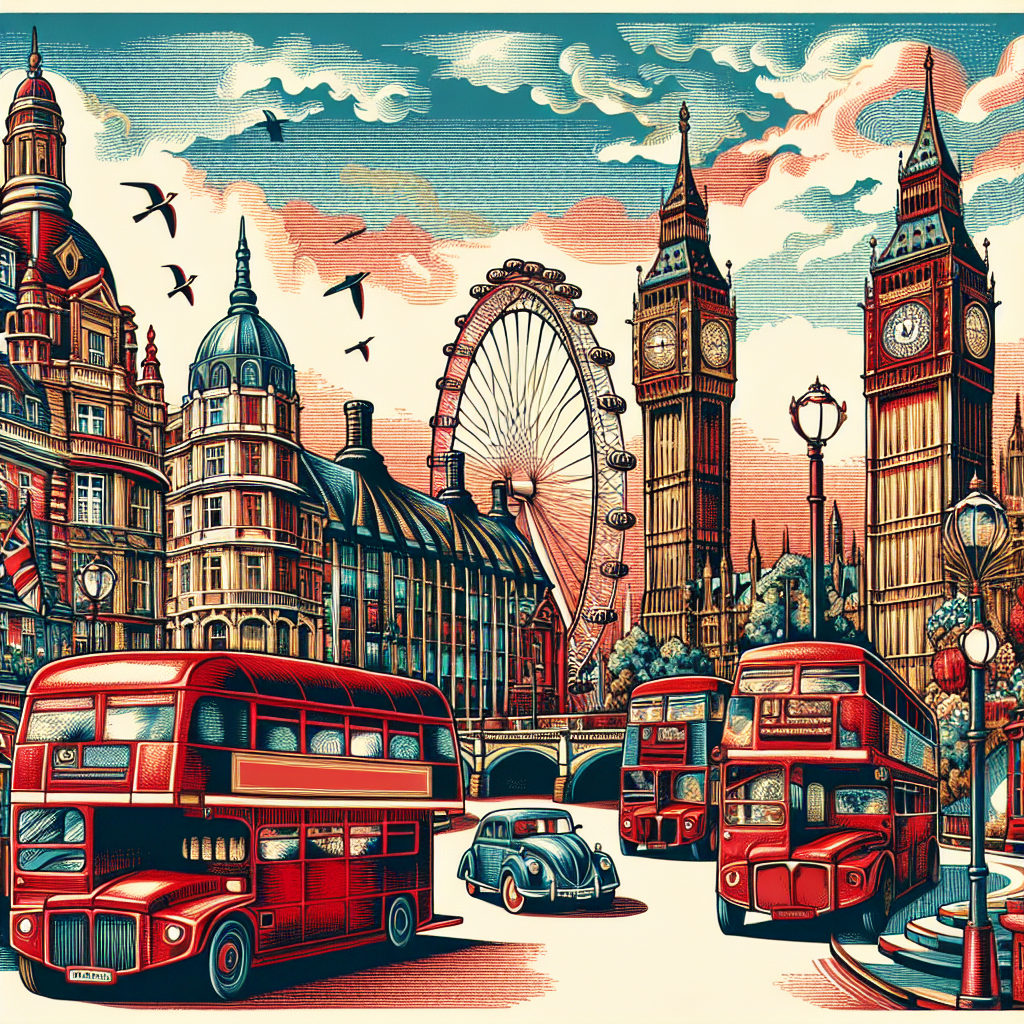

In [18]:
image = artist("London")
display(image)

In [16]:
# Function to add speech feature to our chat_bot
def talker(message):
    response = openai.audio.speech.create(
      model="gpt-4o-mini-tts",
      voice="onyx",    
      input=message
    )
    return response.content

In [17]:
# Function for gradio regarding callback. It outputs text,image and speech
def chat(history):
    history = [{"role":h["role"], "content":h["content"]} for h in history]
    messages = [{"role": "system", "content": system_message}] + history
    response = openai.chat.completions.create(model=MODEL, messages=messages, tools=tools)
    cities = []
    image = None

    while response.choices[0].finish_reason=="tool_calls":
        message = response.choices[0].message
        responses, cities = handle_tool_calls_and_return_cities(message)
        messages.append(message)
        messages.extend(responses)
        response = openai.chat.completions.create(model=MODEL, messages=messages, tools=tools)

    reply = response.choices[0].message.content
    history += [{"role":"assistant", "content":reply}]

    voice = talker(reply)

    if cities:
        image = artist(cities[0])
    
    return history, voice, image


In [18]:
# Auxillary function for gradio chat function
def handle_tool_calls_and_return_cities(message):
    responses = []
    cities = []
    for tool_call in message.tool_calls:
        if tool_call.function.name == "get_ticket_price":
            arguments = json.loads(tool_call.function.arguments)
            city = arguments.get('destination_city')
            cities.append(city)
            price_details = get_ticket_price(city)
            responses.append({
                "role": "tool",
                "content": price_details,
                "tool_call_id": tool_call.id
            })
    return responses, cities

In [20]:
# Callbacks (along with the chat() function above)

def put_message_in_chatbot(message, history):
        return "", history + [{"role":"user", "content":message}]

# UI definition

with gr.Blocks() as ui:
    with gr.Row():
        chatbot = gr.Chatbot(height=500, type="messages")
        image_output = gr.Image(height=500, interactive=False)
    with gr.Row():
        audio_output = gr.Audio(autoplay=True)
    with gr.Row():
        message = gr.Textbox(label="Chat with our AI Assistant:")

# Hooking up events to callbacks

    message.submit(put_message_in_chatbot, inputs=[message, chatbot], outputs=[message, chatbot]).then(
        chat, inputs=chatbot, outputs=[chatbot, audio_output, image_output]
    )

ui.launch(inbrowser=True, auth=("guest", "guest"))

* Running on local URL:  http://127.0.0.1:7861
* To create a public link, set `share=True` in `launch()`.


DATABASE TOOL CALLED: Getting price for Paris
